<a href="https://colab.research.google.com/github/Renshui-MC/DeepLearning-ZerosToGans/blob/main/Training%20deep%20NN%20on%20GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using GPU for training**
+ training on GPU can be a lot faster than that on CPU, e.g., minutes vs hours!!

+ we have to first enable the GPU option from "Runtime" 

## Preparing the Data

Recall that linear-regression logistic regression model is used to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a **linear relationship** between **pixel intensities and image labels**.

In this post, we'll try to improve upon it  using a **feed-forward neural network** which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [341]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`. 

+ `transform=ToTensor()`: images are downloaded as pytorch tensor shape: `1x28x28`(color channel, width, height)

+ `plt.imshow` is used to display the images. This object requirs **the color channel to be the last dimension in an image tensor**. so use `permute` method to reorder the dimensions of the images 

+ `root='data/'`: datasets are downloaded to the specified root


In [342]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

+ `image, label = dataset[0]` means the first image of the dataset: `image` contains $28 \times 28$ pixels

+ we check the original image shape, i.e., `image.shape` and gets `[1, 28, 28]`

+ `image.permute()` can be used to reorder the dimensions, e.g., `image.permute(1,2,0)` that puts the first dimension as the last dimension

In [343]:
image, label = dataset[0]
print(image.shape)
print(image.permute(1,2,0).shape) 
print(image[0].shape)                 

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([28, 28])


use `image[0]` to remove the color channel dimension. Otherwise we will get an error message. 

image.shape: torch.Size([1, 28, 28])
Label: 5


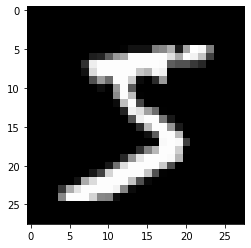

In [344]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside $10000$ images for our **validation set**.

+ choose the size of the **validation set** 
+ choose the size of the **training set** 

In [345]:
len(dataset)

60000

In [346]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create `PyTorch` data loaders for **training and validation**.

+ specify the batch size = $128$ for `DataLoader`
+ `num_workers=4`: Setting the argument `num_workers` as a positive integer will turn on **multi-process data loading** with the specified number of loader worker processes
+ setting `pin_memory=True`, which enables fast data transfer to **CUDA-enabled GPUs**



In [347]:
batch_size = 128

In [348]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. 

+ `.permute` is needed to move the channel color dimension to the last dimension for `matplotlib` to work
+  `nrow` number of images displayed in each row of the grid
+ `grid.shape torch.Size([3, 242, 482])` ($242$ is height and $482$ is width) shows that the channel dimension is on the first index, and we need to move it to the last index to be compatible with `imshow`
+ $16 \times 8 = 128$ (a batch size)
+ `plt.figure(figsize=(16,8))` is just used to control the figure size. You can change `(16,8)` to a different pair to see how figure size changes
+ `nrow = 16` represents the number of columns in the output figure. Why $16$? While it can be any number, $16$ is chosen because $128$ is completely divisible by $16$. You can also set `nrow = 8` and the figure changes its shape of representation  


In [349]:
for images, _ in train_loader:
    print('image.shape:', images.shape)
    print('grid.shape', make_grid(images, nrow=16).shape)
    break

image.shape: torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


images.shape: torch.Size([128, 1, 28, 28])


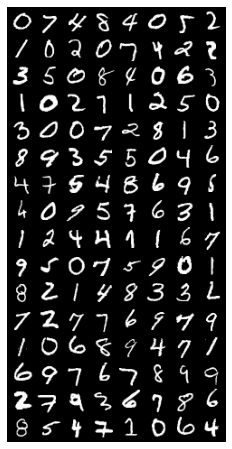

In [350]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## **Hidden Layers, Activation Functions and Non-Linearity**

We'll create a neural network with two layers: a **hidden layer** and an **output layer**. Additionally, we'll use an **activation function** between the two layers 

+ how **hidden layers** and **activation functions** can help capture non-linear relationships between inputs and outputs

+ First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object

1. `images` contains a set of batches 

2. Recall linear regression takes only a one-dimensional vector of each batch, therefore we have to convert $28 \times 28$ into $784$ (2D to 1D)

In [351]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])


In [352]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object as our **hidden layer**. 

+ We'll set the size of the output from the hidden layer to $32$. (This number can be increased or decreased to change the **learning capacity** of the model.)

+ recall the **linear logistic regression model** `model = nn.Linear(input_size, num_classes)` takes `input_size` ($784$ one image contains $28 \times 28$ pixels) and `num_classes` ($10$ outputs)

+ here we use the same `input_size` ($784$) but **set the intermediate hidden layer** be $32$ for the output

In [353]:
input_size = inputs.shape[-1]
hidden_size = 32

print('input_size: ',input_size)

input_size:  784


**input_size:** $784$ \\
**hidden_size:** $32$ (a different value can be used)

**Step one:** created layer one

In [354]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

+ `inputs` ($128 \times 784$) is converted to the dimension (reshape(-1, 784)) that is compatible with the `nn.Linear()` model

+ `layer1` is a linear regression model, which contains **weights** (layer1.weights) and **bias** (layer1.biase)

In [355]:
inputs.shape

torch.Size([128, 784])

In [356]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The **inputs matrix** ($128 \times 784$) is transformed into **intermediate output matrix** ($128 \times 32$) by performing a **direct matrix multiplication**:

+  `inputs` matrix with the **transposed weights matrix** of `layer1` and adding the bias. 

+ recall **weights** dimensions: number of training examples ($128$) times number of outputs ($32$), and **bias** dimension is number of outputs ($32$)

We can verify this using `torch.allclose`. 

In [357]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [358]:
print('weights dimensions: ', layer1.weight.shape)
print('bias dimensions: ', layer1.bias.shape)
print('inputs dimensions: ', inputs.shape)

weights dimensions:  torch.Size([32, 784])
bias dimensions:  torch.Size([32])
inputs dimensions:  torch.Size([128, 784])


`layer1` and direct matrix operation give the same results, and we get "True"

In [359]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

## linear relationship

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements ($728$ pixels) from `inputs`. 

Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

## non-linear relationship (activation function removing negative values)
Next, we'll use the **Rectified Linear Unit (ReLU) function** as the **activation function** for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. **ReLU is a non-linear function**, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [360]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

+ note that `F.relu` does not change the shape

**Step two:** taking the outputs from `layer1` at **step one** to create a **nonlinear layer output** `relu_outputs`

In [361]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape torch.Size([128, 32])
min(layer1_outputs): -0.6573352813720703
min(relu_outputs): 0.0


With the **activation function** `ReLU`, the relationship between`relu_outputs` and `inputs` is no longer linear. 

+ for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

+ Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length $10$, which is the desired output of our model (since there are $10$ target labels).

_Quesiont: why is this Rectified activation function good?_ \\
Ans: it removes the negtive values that are not physically realistic

In [362]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

**Step three:** taking the nonlinear output results (`relu_outputs`) from **step two** to create a linear relationship (`layer2_outputs`)

In [363]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


## Gradient descent (`cross_entry`)
As expected, `layer2_outputs` contains a batch of vectors of size $10$. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using **gradient descent.**

In [364]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3162, grad_fn=<NllLossBackward0>)

Thus, our model 

1. transforms `inputs` into `layer2_outputs` by applying a **linear transformation** (using `layer1`),
2. followed by a **non-linear activation** (using `F.relu`), 
3. followed by another **linear transformation** (using `layer2`). 

Let's verify this by re-computing the output using basic matrix operations.

In [365]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [366]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

1. Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. 
2. we train the model and adjust **ONLY** the weights of `layer1` and `layer2`, 
3. we can now capture non-linear relationships between the images and their labels. In other words, **introducing non-linearity** makes the model more powerful and versatile.
4. since `hidden_size` does **NOT** depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model.
5. We can also introduce **new hidden layers** and apply the same non-linear activation after each hidden layer (**multi-layered relationships**). 

The model we just created is called **a neural network**. A **deep neural network** is simply **a neural network with one or more hidden layers**. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices (**weights and biases**), applying **non-linear activations**, and adjusting **weights repeatedly using gradient descent** can yield such **astounding results**. 

Deep learning models often contain **millions of parameters**, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation **between the two linear layers**, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

_Question:_ must it be a linear relationship between the first input layer and the final output layer?

Activation function add non-linearity and changes the linear relationship.

In [367]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

recall **input_size:** $784$, and **output_size:** $10$ 

In [368]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

inputs passed to `layer1` and `layer2` is same as inputs passed to the **combined layer**

In [369]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [370]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with **one hidden layer**. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of **inputs** (**pixel intensities**) into **outputs** (**class probabilities**), we'll use two `nn.Linear` objects. Each of these is called a **layer** in the network. 

* The **first layer** (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear **activation function** to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the **activation function**, which is also of size `batch_size x hidden_size`, is passed into the **second layer** (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. 
* We can use this output to compute the loss and adjust **weights using gradient descent**.

Usually, **input and target output** are not called layers.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

+ `xb` is the original two dimensional images data that need to be flatten
+ `in_size` is $784$



In [371]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

+ outputs are the **probabilities of each label**

In [372]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [373]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [374]:
model = MnistModel(input_size, hidden_size, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

+ layer one takes $784$ inputs and generates $32$ outputs
+ layer two takes $32$ inputs and generates $10$ outputs

In [375]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of $128$ images from our dataset and pass them into our model.

In [376]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3209307193756104
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0356, -0.1695,  0.0751,  0.1109, -0.0104,  0.1900, -0.0622, -0.0057,
         -0.1033,  0.0200],
        [-0.0032, -0.1116,  0.0921, -0.0113,  0.0056,  0.2184, -0.0395,  0.0377,
         -0.0207,  0.0357]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use **GPUs** to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

+ CUDA is the language used to communicate with the GPU

In [377]:
torch.cuda.is_available()

False

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

+ **Always** check if a GPU is avaiable by doing the following
+ `torch.device('cuda')` returns a pointer to the GPU
+ `torch.device('cpu')` returns a pointer to the CPU

In [378]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [379]:
device = get_default_device()
device

device(type='cpu')

Next, let's define a function (`to_device`) that can move data and model to a chosen device, `isinstance()` ensures only a **tensor** or a **model** is moved to the interested device
+ both `tensor` or `model` in pytorch have `to` method 
+ data by default are sitting on **CPU** and we need to move them to **GPU**
+ CPU memory is usually much larger than the GPU memory
+ we move the data to the device we just checked above, e.g., GPU or CPU, the data can be either a **tensor** or a **model**
+ we can move `to_device` to move multiple tensors **at once**


In [380]:
#move a model or a tensor to GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

`.device` method to check where data are stored

In [381]:
for images, labels in train_loader:
    print(images.shape)
    print(images.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we **don't need** to extend an existing class to create a PyTorch data loader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

* `dl` dataloader
* `self.dl` and `self.device` store the arguments in the current object
* `__iter__()` function returns an iterator object that goes through the each element of the given object, otherwise you cannot use `for` to loop through all batches
+ `__len__()` returns the number of batches  
* we should use `yield` when we want to iterate over a sequence, but don’t want to store the entire sequence in memory. `yield` is used in **Python generators**




In [382]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        print('Minghan one')
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        print('you are in __iter()__')
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        print('You are in __len__(self)')
        """Number of batches"""
        return len(self.dl)

`num` is the output (yield) of the method `nextSquare()`

In [383]:
def nextSquare():
    i = 1
 
    # An Infinite loop to generate squares
    while True:
        yield i*i
        i += 1  # Next execution resumes
        # from this point
 
 
# Driver code to test above generator
# function
for num in nextSquare():
    if num > 100:
        break
    print(num)

1
4
9
16
25
36
49
64
81
100


The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [384]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`.

+ `train_loader` and `val_loader` objects are iterator objects that contain two attributes `dl` and `device`

In [385]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Minghan one
Minghan one


In [386]:
train_loader.device
train_loader.__len__()
train_loader.__iter__()

You are in __len__(self)


<generator object DeviceDataLoader.__iter__ at 0x7f678ebadb30>

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

+ `for` can be used to loop through all batches due to `__iter__()` defined in the `DeviceDataLoader()`

In [387]:
for xb, yb in val_loader:
    print('yb.device:', yb.device)
    print('yb:', yb)
    break

you are in __iter()__
yb.device: cpu
yb: tensor([0, 5, 3, 9, 1, 0, 0, 9, 4, 7, 5, 0, 1, 5, 9, 1, 5, 3, 4, 7, 5, 2, 1, 9,
        7, 6, 2, 0, 6, 8, 2, 0, 7, 3, 1, 3, 9, 5, 4, 0, 0, 2, 4, 1, 9, 0, 8, 1,
        2, 2, 1, 8, 1, 4, 7, 8, 7, 9, 7, 5, 4, 6, 5, 5, 9, 8, 2, 6, 8, 9, 2, 8,
        8, 5, 3, 8, 4, 0, 8, 8, 6, 0, 2, 9, 4, 2, 7, 8, 5, 0, 1, 3, 0, 7, 6, 1,
        4, 8, 9, 0, 0, 0, 6, 3, 6, 1, 0, 4, 2, 4, 4, 1, 7, 8, 2, 3, 7, 7, 9, 9,
        2, 7, 8, 1, 4, 9, 2, 3, 2, 0, 1, 3, 7, 1, 1, 6, 2, 8, 3, 8, 0, 3, 4, 9,
        4, 4, 2, 6, 0, 1, 3, 4, 5, 1, 3, 3, 4, 2, 3, 4, 9, 5, 3, 1, 9, 2, 1, 6,
        3, 6, 1, 8, 8, 9, 3, 4, 3, 7, 2, 6, 5, 0, 6, 3, 9, 1, 8, 5, 1, 2, 4, 6,
        1, 9, 9, 3, 1, 7, 8, 1, 8, 3, 4, 6, 4, 6, 1, 1, 4, 9, 9, 9, 4, 2, 9, 4,
        0, 9, 5, 9, 7, 4, 6, 3, 6, 2, 6, 6, 1, 0, 0, 7, 6, 0, 6, 6, 5, 1, 4, 7,
        7, 6, 1, 7, 7, 4, 8, 5, 1, 1, 6, 4, 7, 4, 3, 3])


In [388]:
print('xb.shape',xb.shape)
print('yb.shape',yb.shape)

xb.shape torch.Size([256, 1, 28, 28])
yb.shape torch.Size([256])


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [389]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history